# 1. Codebase

In [1]:
import inspect
from pprint import pprint
import torch
from torch_geometric.utils import scatter_




class LinkMessagePassing(torch.nn.Module):
    r"""Base class for creating message passing layers

    .. math::
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \square_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{i,j}\right) \right),

    where :math:`\square` denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean or max, and :math:`\gamma_{\mathbf{\Theta}}`
    and :math:`\phi_{\mathbf{\Theta}}` denote differentiable functions such as
    MLPs.
    See `here <https://rusty1s.github.io/pytorch_geometric/build/html/notes/
    create_gnn.html>`__ for the accompanying tutorial.

    """

    def __init__(self, aggr='add'):
        super(LinkMessagePassing, self).__init__()
        
        # this calls will get all params of the self.message() func
        # defined in the instance that inherits from this class
        #  ecample def message(self, x_j, norm) -> x_j and norm
        self.message_args = inspect.getargspec(self.message)[0][1:]
        # with GCN this is [x_j, norm]
        self.update_args = inspect.getargspec(self.update)[0][2:]
        # with GCN this is []

    #def propagate(self, aggr, edge_index, edge_neighbors, **kwargs):
    #def propagate(self, aggr, edge_index, **kwargs):
    def propagate(self, aggr, edge_neighbors, **kwargs):
        r"""The initial call to start propagating messages.
        Takes in an aggregation scheme (:obj:`"add"`, :obj:`"mean"` or
        :obj:`"max"`), the edge indices, and all additional data which is
        needed to construct messages and to update node embeddings."""

        assert aggr in ['add', 'mean', 'max']
        #kwargs['edge_index'] = edge_index
        kwargs['edge_neighbors'] = edge_neighbors
        #print("self update_args: ", self.update_args)
        
        #print("self message_args: ",self.message_args)
        #print("kwargs: ",kwargs)
        size = None
        message_args = []
        for arg in self.message_args:
            if arg[-2:] == '_i':
                tmp = kwargs[arg[:-2]]
                size = tmp.size(0)
                message_args.append(tmp[edge_index[0]])
            elif arg[-2:] == '_j':
                tmp = kwargs[arg[:-2]]
                size = tmp.size(0)
                message_args.append(tmp[edge_index[1]]) #appends x tensors of the selected nodes in edge list
            elif arg[-2:] == '_l':
                # this branch is for link/edge feature based messages
                """
                   create a edge_neighborhood list
                   this lists says which edge index corresponds to neighbors of the current edge
                   the messages passed will correspond to those of the edge_neighbors
                  
                   some idea would be: use the same, just change messages from links and change
                   x features to correspond to edges, maybe add as xedge
                   
                   so message would be xedges[neighbor_edge_list]
                   
                   norm would be the same           
                   
                   way propagate is called changes from LinkGCNConv
                   message and update parameteres change also
                   
                   maybe: the aggregate could take into account that there's 2 ends of an edge,
                   like aggregating from each side and doing a mean 

                """
                tmp = kwargs[arg[:-2]] # this is the values of the edge betweennesses for each edge
                size = tmp.size(0)
                message_args.append(tmp[edge_neighbors[0]]) #appends x tensors of the selected nodes in edge list
            else:
                message_args.append(kwargs[arg]) # appends full norm tensor
        #print("message_args: ")
        #pprint(message_args)
        update_args = [kwargs[arg] for arg in self.update_args]
        
        #print("update_args: ", update_args)
        out = self.message(*message_args)

        #print("\n normalized messages (edge attribute) ")
        #pprint(out)
        #print("\n edge_neighbor index used ")
        #pprint(edge_neighbors[0])

        
        out = scatter_(aggr, out, edge_neighbors[0], dim_size=size)
        #print("\n scatter output ")
        #pprint(out)

        out = self.update(out, *update_args)

        #print("\n")

        return out

    def message(self, x_j):  # pragma: no cover
        r"""Constructs messages in analogy to :math:`\phi_{\mathbf{\Theta}}`
        for each edge in :math:`(i,j) \in \mathcal{E}`.
        Can take any argument which was initially passed to :meth:`propagate`.
        In addition, features can be lifted to the source node :math:`i` and
        target node :math:`j` by appending :obj:`_i` or :obj:`_j` to the
        variable name, *.e.g.* :obj:`x_i` and :obj:`x_j`."""

        return x_j

    def update(self, aggr_out):  # pragma: no cover
        r"""Updates node embeddings in analogy to
        :math:`\gamma_{\mathbf{\Theta}}` for each node
        :math:`i \in \mathcal{V}`.
        Takes in the output of aggregation as first argument and any argument
        which was initially passed to :meth:`propagate`."""

        return aggr_out


In [2]:
import torch
from torch.nn import Parameter
from torch_scatter import scatter_add
#from torch_geometric.nn.conv import MessagePassing
#from torch_geometric.nn.conv import LinkMessagePassing
from torch_geometric.utils import add_self_loops

from torch_geometric.nn.inits import glorot, zeros
#from ..inits import glorot, zeros


class LinkGCNConv(LinkMessagePassing):
    r"""The graph convolutional operator from the `"Semi-supervised
    Classfication with Graph Convolutional Networks"
    <https://arxiv.org/abs/1609.02907>`_ paper

    .. math::
        \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
        \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},

    where :math:`\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}` denotes the
    adjacency matrix with inserted self-loops and
    :math:`\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}` its diagonal degree matrix.

    Args:
        in_channels (int): Size of each input sample.
        out_channels (int): Size of each output sample.
        improved (bool, optional): If set to :obj:`True`, the layer computes
            :math:`\mathbf{\hat{A}}` as :math:`\mathbf{A} + 2\mathbf{I}`.
            (default: :obj:`False`)
        bias (bool, optional): If set to :obj:`False`, the layer will not learn
            an additive bias. (default: :obj:`True`)
    """

    def __init__(self, in_channels, out_channels, improved=False, bias=True):
        super(LinkGCNConv, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.improved = improved

        self.weight = Parameter(torch.Tensor(in_channels, out_channels))

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()

    def reset_parameters(self):
        glorot(self.weight)
        zeros(self.bias)

    def forward(self, x, edge_neighbors, edge_weight=None):
        """
            needs to be changed to have:
            - edge_neighborhoods
            - xedge as features for edges
            - aggregate function 

        """
        if edge_weight is None:
            edge_weight = torch.ones(
                (edge_neighbors.size(1), ), dtype=x.dtype, device=x.device)
        edge_weight = edge_weight.view(-1)
        assert edge_weight.size(0) == edge_neighbors.size(1)

        edge_neighbors = add_self_loops(edge_neighbors, num_nodes=x.size(0))
        loop_weight = torch.full(
            (x.size(0), ),
            1 if not self.improved else 2,
            dtype=x.dtype,
            device=x.device)
        edge_weight = torch.cat([edge_weight, loop_weight], dim=0)

        row, col = edge_neighbors
        deg = scatter_add(edge_weight, row, dim=0, dim_size=x.size(0))
        deg_inv = deg.pow(-0.5)
        deg_inv[deg_inv == float('inf')] = 0

        norm = deg_inv[row] * edge_weight * deg_inv[col]

        x = torch.matmul(x, self.weight)
        return self.propagate('add', edge_neighbors, x=x, norm=norm)

    def message(self, x_l, norm):
        return norm.view(-1, 1) * x_l

    def update(self, aggr_out):
        if self.bias is not None:
            aggr_out = aggr_out + self.bias
        return aggr_out

    def __repr__(self):
        return '{}({}, {})'.format(self.__class__.__name__, self.in_channels,
                                   self.out_channels)


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import LinkGCNConv
from torch_geometric.nn import SAGEConv
import torch.nn as nn
from pprint import pprint

import networkx as nx
import time
from torch_geometric.data import DataLoader
import importlib
from torch_geometric.data import Data
import pickle
import numpy as np


class MyOwnDataset2_old():
    def __init__(self,  root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 
        #print(self.data)
        #print(self.data.edge_index)
        #print(self.data.num_features)
        self.num_features = self.data.num_features
        self.num_classes = 1
        self.filename = name
        
        
        # prepare edge_neighbors
        edges_dict = {}
        i=0
        for edge in self.data.edge_index[0]:
            edges_dict[i]= (self.data.edge_index[0][i],
                            self.data.edge_index[1][i])
            i+=1

        #print("\n edges_dict:")
        #pprint(edges_dict)
        #print("\n")
        """
            {
            0 : (1,3),
            1 : (1,4),
            2 : (2,0)
            ...
            }

            edge_neighbors= [[],[]]
            for edge in edges_dict.keys():
                for node in edges_dict[edge]:
                    for edge2 in edges_dict.keys():
                        if edge2 != edge and \
                           ( edges_dict[edge2][0] == node or \
                             edges_dict[edge2][1] == node ):
                             edge_neighbors[0].append(edge)
                             edge_neighbors[1].append(edge2)

        """
        edge_neighbors= [[],[]]
        for edge in edges_dict.keys():
            for node in edges_dict[edge]:
                for edge2 in edges_dict.keys():
                    if edge2 != edge and ( edges_dict[edge2][0] == node or edges_dict[edge2][1] == node ):
                        edge_neighbors[0].append(edge)
                        edge_neighbors[1].append(edge2)

        self.data.edge_neighbors = torch.LongTensor(edge_neighbors)

        #print()
        #print("edge_neighbors")
        #pprint(self.data.edge_neighbors)
        #print()
        #print(type(self.data.edge_neighbors))
        #print()
        
        f.close()
        
class MyOwnDataset2():
    def __init__(self,  root, name, transform=None, pre_transform=None):
        f = open(name, 'rb')
        self.data = pickle.load(f) 

        self.num_features = self.data.num_features
        self.num_classes = 1
        self.filename = name
         
        f.close()

        
class MyNet():

    def __str__(self):
        #print(dir(self))
        #print()
        #print([attr+"-"+str(getattr(self,attr)) for attr in dir(self) if attr.startswith("d")])
        hp = [attr+"="+str(getattr(self,attr)) for attr in dir(self) if attr.startswith("d") and len(attr)==2]
        hp = "_".join(hp)
        return "%s-%s" % (self.__class__.__name__,hp)
        #return "%s-gcn(%d,%d)-gcn(%d,%d)" % (self.__class__.__name__,dataset.num_features,self.d1,self.d1,
        #         

class NetLGCN1(torch.nn.Module,MyNet):
    def __init__(self, d1=16,num_features=1, num_classes=1):
        super(NetLGCN1, self).__init__()
        self.conv1 = LinkGCNConv(num_features, d1)
        self.conv2 = LinkGCNConv(d1, num_classes)
        self.d1 = d1
        

    def forward(self, data):
        x, edge_neighbors = data.x, data.edge_neighbors

        x = self.conv1(x, edge_neighbors)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_neighbors)

        # output as multiclass target
        #return F.log_softmax(x, dim=1)
        
        # output as regression target
        return x
    

class NetLGCN2(torch.nn.Module, MyNet):
    def __init__(self, d1=16,d2=16,num_features=1, num_classes=1):
        super(NetLGCN2, self).__init__()
        self.conv1 = LinkGCNConv(num_features, d1)
        self.fc1 = nn.Linear(d1, d2)
        self.fc2 = nn.Linear(d2, num_features)
        self.d1 = d1
        self.d2 = d2
        

    def forward(self, data):
        x, edge_neighbors = data.x, data.edge_neighbors

        x = self.conv1(x, edge_neighbors)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # output as multiclass target
        #return F.log_softmax(x, dim=1)
        
        # output as regression target
        return x
    
    
class NetLGCN3(torch.nn.Module, MyNet):
    def __init__(self, d1=16,d2=16,d3=10,num_features=1, num_classes=1):
        super(NetLGCN3, self).__init__()
        self.conv1 = LinkGCNConv(num_features, d1)
        self.conv1 = LinkGCNConv(d1, d2)
        self.fc1 = nn.Linear(d2, d3)
        self.fc2 = nn.Linear(d3, num_classes)
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3

    def forward(self, data):
        x, edge_neighbors = data.x, data.edge_neighbors

        x = self.conv1(x, edge_neighbors)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_neighbors)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # output as multiclass target
        #return F.log_softmax(x, dim=1)
        
        # output as regression target
        return x
    

    

class Net1(torch.nn.Module, MyNet):
    def __init__(self, d1=16,num_features=1, num_classes=1):
        super(Net1, self).__init__()
        self.conv1 = GCNConv(num_features, d1)
        self.conv2 = GCNConv(d1, num_classes)
        self.d1 = d1
        

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        # output as multiclass target
        #return F.log_softmax(x, dim=1)
        
        # output as regression target
        return x
    


    
class Net2(torch.nn.Module, MyNet):
    def __init__(self, d1=300,d2=100,num_features=1, num_classes=1):
        super(Net2, self).__init__()
        self.conv1 = GCNConv(num_features, d1 )
        #self.conv2 = GCNConv(16, dataset.num_classes)
        self.fc1 = nn.Linear(d1, d2)
        self.fc2 = nn.Linear(d2, num_features)
        self.d1 = d1
        self.d2 = d2

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 2 fc layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # output as regression target
        return x
        
    
    #def __str__(self):
    #    return "%s-gcn(%d,%d)-fc(%d,%d)-fc(%d,%d)" % (self.__class__.__name__,dataset.num_features,self.d1,self.d1,
    #                                                    self.d2,self.d2,
    #                                                    dataset.num_features)

    
    
class Net3(torch.nn.Module, MyNet):
    def __init__(self, d1=300,d2=100,num_features=1, num_classes=1):
        super(Net3, self).__init__()
        self.conv1 = SAGEConv(num_features, d1 )
        #self.conv2 = SAGEConv(16, dataset.num_classes)
        self.fc1 = nn.Linear(d1, d2)
        self.fc2 = nn.Linear(d2, num_features)
        self.d1 = d1
        self.d2 = d2
        
        self.num_features = num_features
        self.num_classes = num_classes
        
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 2 fc layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # output as regression target
        return x
        
    def __str__(self):
        return "Net3-SAGEgcn(%d,%d)-fc(%d,%d)-fc(%d,%d)" % (self.num_features,self.d1,self.d1,
                                                        self.d2,self.d2,
                                                        self.num_features)

class Net4(torch.nn.Module, MyNet):
    def __init__(self, d1=300,d2=100,d3=10,num_features=1, num_classes=1):
        super(Net4, self).__init__()
        self.conv1 = GCNConv(num_features, d1 )
        self.conv2 = GCNConv(d1, d2)
        self.fc1 = nn.Linear(d2, d3)
        self.fc2 = nn.Linear(d3, num_features)
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 2 fc layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        # output as regression target
        return x
        
    #def __str__(self):
    #    return "Net4-gcn(%d,%d)-fc(%d,%d)-fc(%d,%d)" % (dataset.num_features,self.d1,self.d1,
    #                                                    self.d2,self.d2,
    #                                                    dataset.num_features)

    
class Net5(torch.nn.Module, MyNet):
    def __init__(self, d1=90,d2=80,d3=50,d4=20,num_features=1, num_classes=1):
        super(Net5, self).__init__()
        self.conv1 = GCNConv(num_features, d1 )
        self.conv2 = GCNConv(d1, d2)
        self.fc1 = nn.Linear(d2, d3)
        self.fc2 = nn.Linear(d3, d4)
        self.fc3 = nn.Linear(d4, num_features)
        self.d1 = d1
        self.d2 = d2
        self.d3 = d3
        self.d4 = d4
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        # 3 fc layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        # output as regression target
        return x



In [179]:
import networkx as nx
import time
import torch
from torch_geometric.data import DataLoader
import importlib
import torch
from torch_geometric.data import DataLoader
import networkx as nx
from torch_geometric.data import Data
import pickle
import math
import pandas as pd
from IPython.display import display, HTML
import os
import math
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
plt.style.use('seaborn-whitegrid')

def loadDataset(collection, name=None):
    try:
        # import datasets
        themodule = importlib.import_module("torch_geometric.datasets")
        # get the function corresponding to collection
        method_to_call = getattr(themodule, collection)
        if name:
            dataset = method_to_call(root='./data/'+str(collection), name=name)
            dataset.filename = name
            return dataset
        else:
            return method_to_call(root='./data/'+str(collection)) 
    except:
        # custom module
        method_to_call = globals()[collection]
       
        if name:
            
            dataset = method_to_call(root='./data/'+str(collection), name=name)
            dataset.filename = name
            return dataset
        else:
            return method_to_call(root='./data/'+str(collection)) 
        

def round_half_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n*multiplier + 0.5) / multiplier

def transformMask(mask):
    train_mask = []
    i = 0
    for pick in mask:
        if pick[0]==1:
            train_mask.append(i)
        i+=1
    return train_mask


def shuffleTrainTestMasks(data, trainpct = 0.7):
    ysize = list(data.y.size())[0]
    data.train_mask = torch.zeros(ysize,1, dtype=torch.long)
    data.train_mask[int(ysize*trainpct):] = 1
    data.train_mask = data.train_mask[torch.randperm(ysize)]
    data.test_mask = torch.ones(ysize,1, dtype=torch.long) - data.train_mask
    
    data.train_mask = transformMask(data.train_mask)
    data.test_mask = transformMask(data.test_mask)
  

def shuffleTrainTestValMasks(data, trainpct = 0.7, valpct = 0.2):

    ysize = list(data.y.size())[0]
    #print("total ", ysize)
    #print(" train ",int(ysize*trainpct)-int(ysize*trainpct*valpct))
    #print(" val ",int(ysize*trainpct*valpct))
    #print(" test ",int(ysize*(1- trainpct) ))
    data.train_mask = torch.zeros(ysize,1, dtype=torch.long)
    data.train_mask[:int(ysize*trainpct)] = 1
    data.train_mask = data.train_mask[torch.randperm(ysize)]
    #print(" train sum ",data.train_mask.sum())
    data.test_mask = torch.ones(ysize,1, dtype=torch.long) - data.train_mask
    #print(" test sum ",data.test_mask.sum())
    
    # transform to list of indexes
    data.train_mask = transformMask(data.train_mask)
    data.test_mask = transformMask(data.test_mask)
    
    data.val_mask = data.train_mask[:int(ysize*trainpct*valpct)]
    data.train_mask = data.train_mask[int(ysize*trainpct*valpct):]

    
    #print(data.train_mask)
    #print(data.val_mask)
    #print(data.test_mask)
    
    
def errors(t,y):
    """
        Compute RMSE and NRMSE
        
        ||t -y ||^2/n is the mean of the size of the error squared
        (mean from all samples)
        
        sqrt(||t-y||^2/n) is the root of this mean of squared errors
        so it has the units of t and y
        
        but the normalization means dividing by maxmin, 
        or sd, or IQR, 
        
        if this term is bigger than the rmse, then nrmse should be smaller than one.
        otherwise it should be bigger than one,
        meaning the error is so big that is is bigger than maxmin distance
        
    """
    num_samples = list(t.size())[0]
    #print("t shape",list(t.size()))
    #print("num_samples", num_samples)
    t_avg = sum(t)/num_samples
    #print("t",t)
    #print("t_avg", t_avg)
    #print("t - t_avg",t - t_avg)
    #print((t - t_avg))
    #print((t - t_avg)**2)
    #print(sum((t - t_avg)**2))
    
    sample_variance = sum((t - t_avg)**2)/(num_samples - 1)
    sample_std = sample_variance.sqrt()
    # in wikipedia they use tmax-tmin or IQR
    maxmin = max(t) - min(t)
    smean = torch.mean(t)
    normalizer = sample_std
    
    #print("normalizer", normalizer)
    rmse = torch.sum((t - y) ** 2)/num_samples
    #nrmse = torch.sum((t - y) ** 2)/((num_samples-1)*sample_variance)
    #nrmse = rmse*num_samples/((num_samples-1)*sample_variance)
    nrmse = rmse
    rmse = rmse.sqrt()
    nrmse = nrmse.sqrt()/normalizer
    #print("rmse",rmse)
    #print("nrmse", nrmse)
    return rmse, nrmse, normalizer

def trainTestEval(dataset, epochs=1, batch_size=32, res_dict={}):
    global Net
    loader = DataLoader(dataset,  shuffle=False)
    i = 0
    #print(loader)
    #print(dir(loader))
    
    G = dataset.data
    #print(G)
    start = time.time()


    # 1.  prepare model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print("using ",device)
    model = Net.to(device)  
    data = G.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()

    # 2.  create a train_mask, and a test_mask (val_mask for further experiments)
    #shuffleTrainTestMasks(data)
    #shuffleTrainTestValMasks(data)
    shuffleTrainTestMasks(data)

    # 3. train some epochs
    for epoch in range(epochs):
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        #if epoch % 25 == 0 :
        #    print("epoch-loss: ",epoch, loss)

    # 4. Model evaluation
    model.eval()
    #  classification in a multiclass setting
    #_, pred = model(data).max(dim=1)
    #correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    #acc = correct / data.test_mask.sum().item()
    #print('Accuracy: {:.4f}'.format(acc))


    # regression 
    pred = model(data)
    #print("target: ",data.y[data.test_mask])
    #print("prediction: ",pred[data.test_mask])
    #print(pred[data.test_mask].type())
    #print(data.y[data.test_mask].type())
    
    # prepare the normalized mean root squared error
    t = data.y[data.test_mask]
    y = pred[data.test_mask]

    negatives = False
    if 0 > (sum(y<0)):
        negatives = True
    rmse, nrmse, normalizer = errors(t,y)
    endtime = time.time()
    
    # getting model hyper params
    hyperparams = ""
    model_ds = [elem+"="+str(getattr(Net, elem)) for elem in dir(Net) if elem.startswith("d") and len(elem)==2]
    hyperparams = "_".join(model_ds)
    theepochs = "epochs="+str(epochs)
    #dataset name
    thedataset = dataset.filename
    # basename
    thedataset = os.path.basename(thedataset)
    # extension
    thedataset = os.path.splitext(thedataset)[0]
    
    result = str(model)+" " \
            +hyperparams+" " \
            +theepochs+" " \
            +str(thedataset)+" " \
            +"rmse="+str(round_half_up(rmse.item(),3))+" " \
            +"nrmse="+str(round_half_up(nrmse.item(),3))+" " \
            +"time="+str(round_half_up(endtime-start,3) )  \
            +" negatives?"+str(negatives) \
            +"\n"
    
    res_dict['tables'][str(model)]={
                            #"model": str(model),
                             "hyperparams": hyperparams,
                             "dataset": str(thedataset),
                             "epochs": epochs,
                             "rmse":round_half_up(rmse.item(),3),
                             "nrmse":round_half_up(nrmse.item(),3),
                             "std":round_half_up(normalizer.item(),3),
                             "time":round_half_up(endtime-start,3),
                            "neg vals": negatives }
    res_dict['scatterplots'][str(model)]={'targets':np.array(t.detach().numpy()), 
                                          'predictions': np.array(y.detach().numpy()) }
    
    with open("results.txt","a") as f:
        #print(dir(dataset))
        #f.write("\n")
        #print(result)
        f.write(result)
    
    del model
    

    
def trainTestEvalAllDataset(dataset, epochs=1, batch_size=32, res_dict={}):
    
    """
        version 1:
        Every graph of the dataset is fed into the algorithm at each epoch
        train/test/val nodes are selected among the same graph

        # transductive setting
        train_list, test_list and val_list are Nx disjoint_unions then back to PyTorchGeom
        for each graph: # this can be done on Dataset_preparation_notebook
            get train nodes -> append to train_list (saves graph and node index)
            get test nodes -> append to test_list
            get val nodes -> append to val list
            
        they can be marked as test/train/val beforehand, but then less randomization of the training will exist
        
        for hyperparameter search
            for each epoch:        
                train(train_list)
            validate(val_list)
            save_best_hyperparams()
            
        test(tes_list, best_hyperparams)

        modelPerformance()
            
            
                
        version 2:(inductive setting)
        Every graph of the dataset is fed into the algorithm at each epoch
        all test/val nodes come from graphs different than those of the train nodes
        
        # inductive setting
        for each graph in train: # this can be done on Dataset_preparation_notebook
            get nodes -> append to train_list (saves graph and node index)
            
        for each graphp in test:
            get nodes -> append to test_list
            
        for each graph in val
            get nodes -> append to val list
        
        for hyperparameter search
            for each epoch:        
                train(train_list)
            validate(val_list)
            save_best_hyperparams()
            
        test(tes_list, best_hyperparams)
        
        modelPerformance()
        
    """
    
    global Net
    start = time.time()


    # 1.  prepare model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    #print("using ",device)
    model = Net.to(device)  
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    model.train()

    
    # 3. train some epochs
    for epoch in range(epochs):
        
        
        # 2.  create a train_mask, and a test_mask (val_mask for further experiments)
        # loader = DataLoader(dataset,  shuffle=False)   # ??
        # for every graph of the dataset
        #   load it, select train/val/ and test nodes
        G = dataset.data
        data = G.to(device)
        #shuffleTrainTestMasks(data)
        #shuffleTrainTestValMasks(data)
        # no longer need for that 20190323
        #shuffleTrainTestMasks(data)


        
        optimizer.zero_grad()
        out = model(data)
        loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        #if epoch % 25 == 0 :
        #    print("epoch-loss: ",epoch, loss)

    # 4. Model evaluation
    model.eval()
    #  classification in a multiclass setting
    #_, pred = model(data).max(dim=1)
    #correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    #acc = correct / data.test_mask.sum().item()
    #print('Accuracy: {:.4f}'.format(acc))


    # regression 
    pred = model(data)
    #print("target: ",data.y[data.test_mask])
    #print("prediction: ",pred[data.test_mask])
    #print(pred[data.test_mask].type())
    #print(data.y[data.test_mask].type())
    
    # prepare the normalized mean root squared error
    t = data.y[data.test_mask]
    y = pred[data.test_mask]

    negatives = False
    if 0 > (sum(y<0)):
        negatives = True
    rmse, nrmse, normalizer = errors(t,y)
    endtime = time.time()
    
    # getting model hyper params
    hyperparams = ""
    model_ds = [elem+"="+str(getattr(Net, elem)) for elem in dir(Net) if elem.startswith("d") and len(elem)==2]
    hyperparams = "_".join(model_ds)
    theepochs = "epochs="+str(epochs)
    #dataset name
    thedataset = dataset.filename
    # basename
    thedataset = os.path.basename(thedataset)
    # extension
    thedataset = os.path.splitext(thedataset)[0]
    
    result = str(model)+" " \
            +hyperparams+" " \
            +theepochs+" " \
            +str(thedataset)+" " \
            +"rmse="+str(round_half_up(rmse.item(),3))+" " \
            +"nrmse="+str(round_half_up(nrmse.item(),3))+" " \
            +"time="+str(round_half_up(endtime-start,3) )  \
            +" negatives?"+str(negatives) \
            +"\n"
    
    res_dict['tables'][str(model)]={
                            #"model": str(model),
                             "hyperparams": hyperparams,
                             "dataset": str(thedataset),
                             "epochs": epochs,
                             "rmse":round_half_up(rmse.item(),3),
                             "nrmse":round_half_up(nrmse.item(),3),
                             "std":round_half_up(normalizer.item(),3),
                             "time":round_half_up(endtime-start,3),
                            "neg vals": negatives }
    res_dict['scatterplots'][str(model)]={'targets':np.array(t.detach().numpy()), 
                                          'predictions': np.array(y.detach().numpy()) }
    
    with open("results.txt","a") as f:
        #print(dir(dataset))
        #f.write("\n")
        #print(result)
        f.write(result)
    
    del model
    
    

def reporting(res_dict):
    df_original = pd.DataFrame(res_dict['tables'])
    df = df_original.T
    #df.style.set_table_styles([ dict(selector='th', props=[('text-align', 'left')] ) ])
    # Assuming that dataframes df1 and df2 are already defined:
    display(df)
    #display(HTML(df.to_html()))
    #print(df)
    
    #now scatter plot for each model (use a grid)
    sp = res_dict['scatterplots']

    # make a grid
    N = len(sp.keys())
    cols = 3
    rows = int(math.ceil(N / cols))

    gs = gridspec.GridSpec(rows, cols)
    fig=plt.figure(figsize=(14, 12), dpi= 60, facecolor='w', edgecolor='k')
    n = 0
    for name,trainres in sp.items():
        
        # subplots
        ax = fig.add_subplot(gs[n])
        n+=1
        
        newt = np.array(trainres['targets'])
        newy = np.array(trainres['predictions'])
        ax.plot(newt, newy,'o', color='black')
        #ax.xlabel('target betweenness')
        #ax.ylabel('betweenness prediction');
        # 45 degree 
        newt = np.append(newt,[0.9,1])
        ax.plot(newt, newt, color = 'red', linewidth = 2)
        # ranges
        #ax.xlim(0, 1)
        #ax.ylim(0, 1)
        # title
        ax.set_title(name)
        
    #fig.suptitle('Scatter plots') # or plt.suptitle('Main title')
    fig.tight_layout()

In [180]:
def experimentBlock(dname, res_dict):
    global Net
    
    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net1(d1=20, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net1(d1=50, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net1(d1=100, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net2(d1=100,d2=15, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net2(d1=50,d2=15, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net2(d1=20,d2=10, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net3(d1=50,d2=10, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net4(d1=80,d2=40,d3=10, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=Net5(d1=100,d2=50,d3=20,d4=5, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net
    
    return

    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=NetLGCN1(d1=100, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net
    
    dataset = loadDataset(
        collection='MyOwnDataset2', 
        name=dname)
    Net=NetLGCN2(d1=100,d2=30, num_features=dataset.num_features, num_classes=dataset.num_classes)
    trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    del Net
    
    #dataset = loadDataset(
    #    collection='MyOwnDataset2', 
    #    name=dname)
    #Net=NetLGCN3(d1=100,d2=30, d3=15, num_features=dataset.num_features, num_classes=dataset.num_classes)
    #trainTestEval(dataset,  epochs=100, res_dict=res_dict)
    #del Net

# 2. Experiments

In [181]:
res_dict={'tables':{}, 'scatterplots':{}}

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,TUDataset_ENZYMES_12_eb,100,d1=20,False,4.266,0.439,0.103,0.104
Net1-d1=50,TUDataset_ENZYMES_12_eb,100,d1=50,False,4.343,0.489,0.113,0.1
Net1-d1=100,TUDataset_ENZYMES_12_eb,100,d1=100,False,4.842,0.555,0.115,0.103
Net2-d1=100_d2=15,TUDataset_ENZYMES_12_eb,100,d1=100_d2=15,False,4.276,0.486,0.114,0.1
Net2-d1=50_d2=15,TUDataset_ENZYMES_12_eb,100,d1=50_d2=15,False,4.433,0.495,0.112,0.095
Net2-d1=20_d2=10,TUDataset_ENZYMES_12_eb,100,d1=20_d2=10,False,4.511,0.522,0.116,0.087
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",TUDataset_ENZYMES_12_eb,100,d1=50_d2=10,False,4.26,0.364,0.085,0.104
Net4-d1=80_d2=40_d3=10,TUDataset_ENZYMES_12_eb,100,d1=80_d2=40_d3=10,False,4.529,0.521,0.115,0.161
Net5-d1=100_d2=50_d3=20_d4=5,TUDataset_ENZYMES_12_eb,100,d1=100_d2=50_d3=20_d4=5,False,7.043,0.429,0.061,0.188


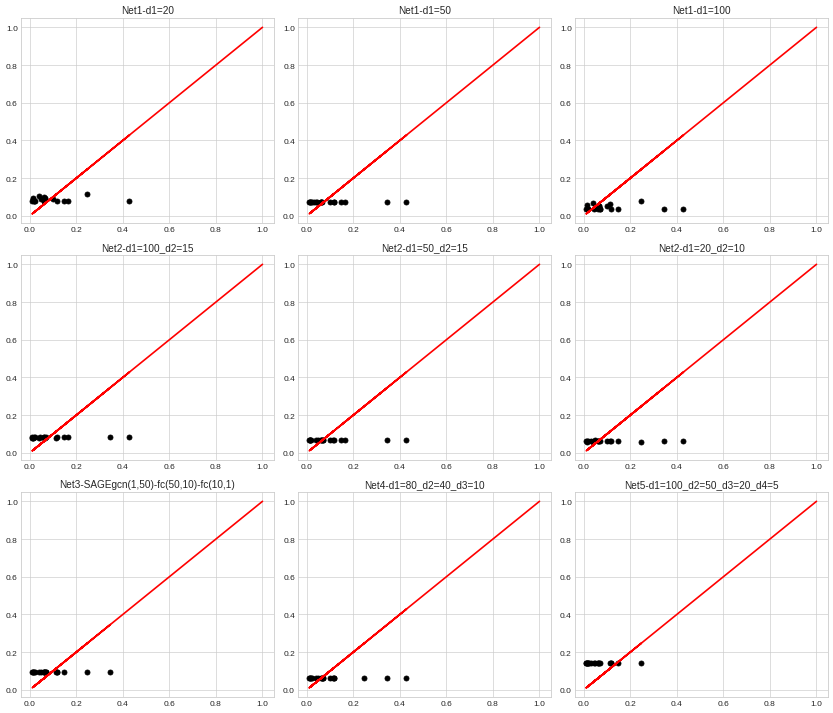

In [182]:
dname='../datasets/precomputed-pytorchg-betweenness/TUDataset_ENZYMES_12_eb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)
# scatterplot (both rmse and nrmse)
# nrmse: mean,sd of train? of test? of all? of prediction? p12ML chap 3   sqrt(||t-Xb||^2/((N-1)Var(sd)))
# sreparatr nrmse for cora and proteins for example
# join proteins : 1 any node test train ,2 separate by grpah (inductive)
#  revisar limitacio gcn graph connex nomes?

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,er_5_0_45_eb,100,d1=20,False,2.491,0.125,0.05,0.106
Net1-d1=50,er_5_0_45_eb,100,d1=50,False,3.189,0.153,0.048,0.1
Net1-d1=100,er_5_0_45_eb,100,d1=100,False,7.074,0.177,0.025,0.094
Net2-d1=100_d2=15,er_5_0_45_eb,100,d1=100_d2=15,False,2.086,0.12,0.058,0.087
Net2-d1=50_d2=15,er_5_0_45_eb,100,d1=50_d2=15,False,3.449,0.165,0.048,0.086
Net2-d1=20_d2=10,er_5_0_45_eb,100,d1=20_d2=10,False,3.099,0.148,0.048,0.084
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",er_5_0_45_eb,100,d1=50_d2=10,False,3.131,0.15,0.048,0.091
Net4-d1=80_d2=40_d3=10,er_5_0_45_eb,100,d1=80_d2=40_d3=10,False,2.074,0.12,0.058,0.126
Net5-d1=100_d2=50_d3=20_d4=5,er_5_0_45_eb,100,d1=100_d2=50_d3=20_d4=5,False,3.152,0.151,0.048,0.144


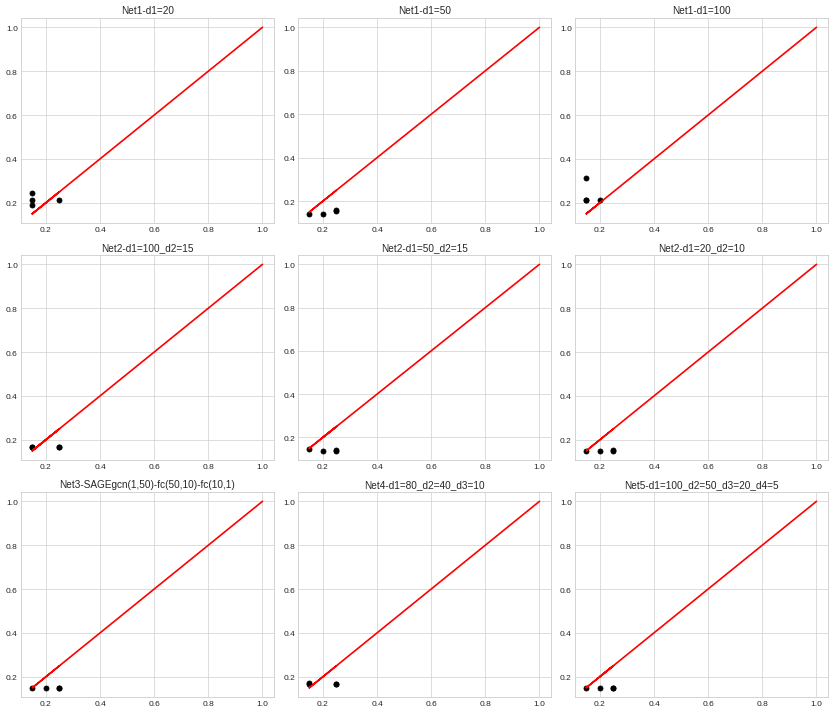

In [183]:
dname='../datasets/precomputed-pytorchg-betweenness/er_5_0_45_eb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,TUDataset_PROTEINS_996_eb,100,d1=20,False,3.392,0.362,0.107,0.116
Net1-d1=50,TUDataset_PROTEINS_996_eb,100,d1=50,False,3.296,0.353,0.107,0.107
Net1-d1=100,TUDataset_PROTEINS_996_eb,100,d1=100,False,5.828,0.354,0.061,0.1
Net2-d1=100_d2=15,TUDataset_PROTEINS_996_eb,100,d1=100_d2=15,False,3.281,0.343,0.105,0.097
Net2-d1=50_d2=15,TUDataset_PROTEINS_996_eb,100,d1=50_d2=15,False,3.672,0.384,0.105,0.089
Net2-d1=20_d2=10,TUDataset_PROTEINS_996_eb,100,d1=20_d2=10,False,3.165,0.339,0.107,0.081
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",TUDataset_PROTEINS_996_eb,100,d1=50_d2=10,False,3.283,0.35,0.106,0.105
Net4-d1=80_d2=40_d3=10,TUDataset_PROTEINS_996_eb,100,d1=80_d2=40_d3=10,False,3.274,0.352,0.108,0.169
Net5-d1=100_d2=50_d3=20_d4=5,TUDataset_PROTEINS_996_eb,100,d1=100_d2=50_d3=20_d4=5,False,3.401,0.195,0.057,0.248


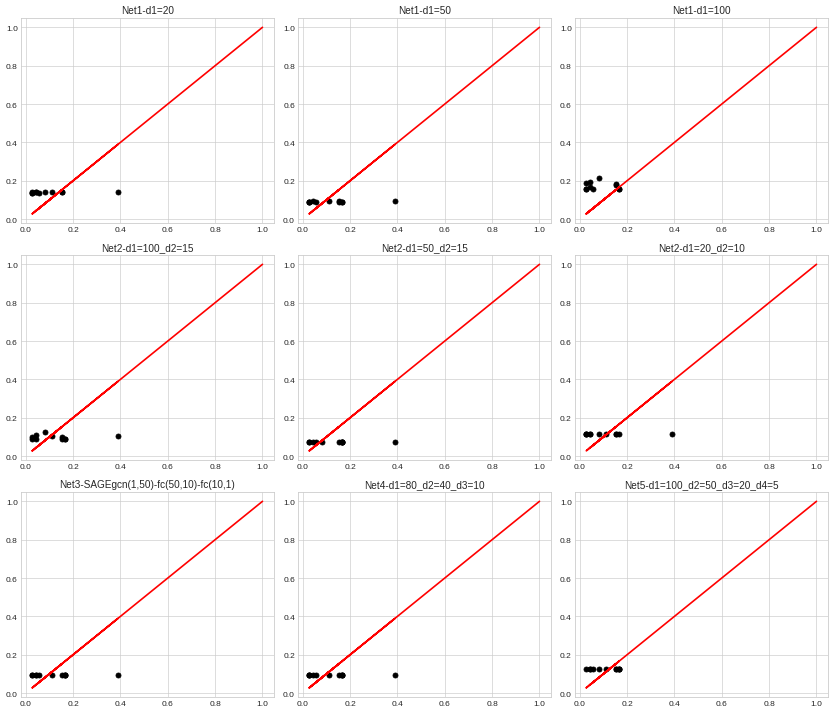

In [184]:
dname='../datasets/precomputed-pytorchg-betweenness/TUDataset_PROTEINS_996_eb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

In [156]:
dname='../datasets/precomputed-pytorchg-betweenness/QM7b_5819_eb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

RuntimeError: index 19 is out of bounds for dim with size 17

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,ws_30_3_0_1_nb,100,d1=20,False,5.338,0.868,0.163,0.101
Net1-d1=50,ws_30_3_0_1_nb,100,d1=50,False,4.736,0.804,0.17,0.1
Net1-d1=100,ws_30_3_0_1_nb,100,d1=100,False,4.517,0.864,0.191,0.113
Net2-d1=100_d2=15,ws_30_3_0_1_nb,100,d1=100_d2=15,False,4.572,0.849,0.186,0.108
Net2-d1=50_d2=15,ws_30_3_0_1_nb,100,d1=50_d2=15,False,4.473,0.818,0.183,0.1
Net2-d1=20_d2=10,ws_30_3_0_1_nb,100,d1=20_d2=10,False,4.638,0.766,0.165,0.087
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",ws_30_3_0_1_nb,100,d1=50_d2=10,False,4.869,0.921,0.189,0.107
Net4-d1=80_d2=40_d3=10,ws_30_3_0_1_nb,100,d1=80_d2=40_d3=10,False,4.538,0.813,0.179,0.162
Net5-d1=100_d2=50_d3=20_d4=5,ws_30_3_0_1_nb,100,d1=100_d2=50_d3=20_d4=5,False,4.496,0.584,0.13,0.184


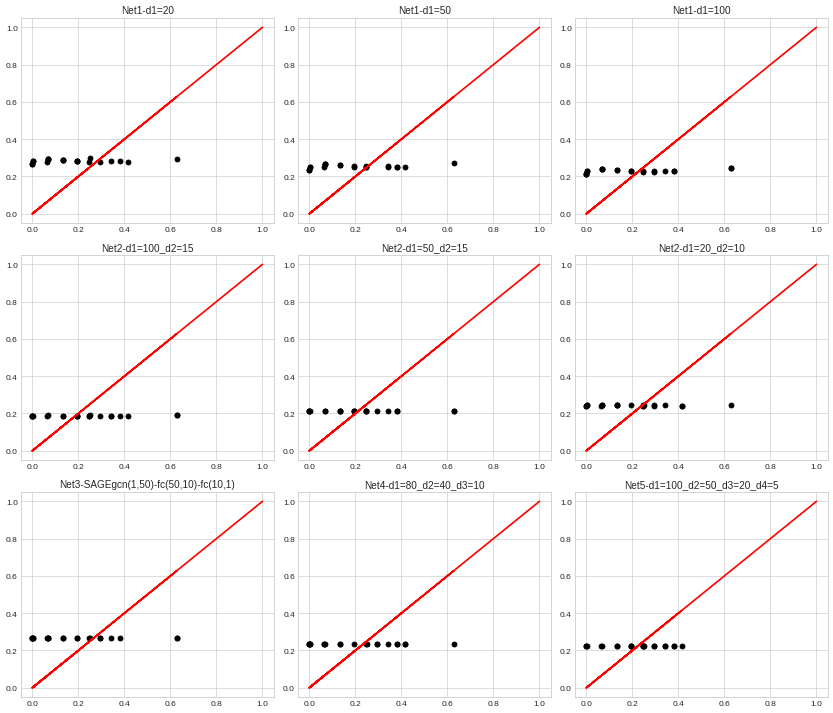

In [185]:
dname='../datasets/precomputed-pytorchg-betweenness/ws_30_3_0_1_nb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

In [ ]:
dname='../datasets/precomputed-pytorchg-betweenness/ws_1000_10_0_1_nb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

In [ ]:
dname='../datasets/precomputed-pytorchg-betweenness/ba_1000_5_nb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,ba_100_5_nb,100,d1=20,False,8.425,0.174,0.021,0.124
Net1-d1=50,ba_100_5_nb,100,d1=50,False,8.635,0.206,0.024,0.176
Net1-d1=100,ba_100_5_nb,100,d1=100,False,9.771,0.221,0.023,0.204
Net2-d1=100_d2=15,ba_100_5_nb,100,d1=100_d2=15,False,8.654,0.176,0.02,0.231
Net2-d1=50_d2=15,ba_100_5_nb,100,d1=50_d2=15,False,8.374,0.155,0.019,0.182
Net2-d1=20_d2=10,ba_100_5_nb,100,d1=20_d2=10,False,8.538,0.205,0.024,0.13
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",ba_100_5_nb,100,d1=50_d2=10,False,8.598,0.152,0.018,0.205
Net4-d1=80_d2=40_d3=10,ba_100_5_nb,100,d1=80_d2=40_d3=10,False,9.043,0.153,0.017,0.37
Net5-d1=100_d2=50_d3=20_d4=5,ba_100_5_nb,100,d1=100_d2=50_d3=20_d4=5,False,8.313,0.195,0.023,0.449


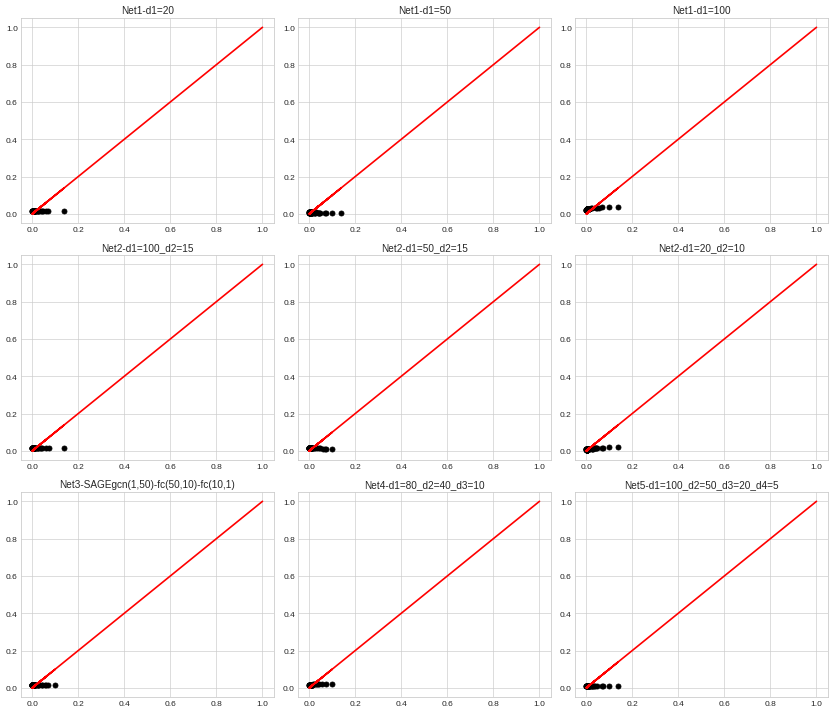

In [186]:
dname='../datasets/precomputed-pytorchg-betweenness/ba_100_5_nb.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

In [21]:
dname='../datasets/precomputed-pytorchg-betweenness/Planetoid_Cora_1_nd.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)

KeyboardInterrupt: 

,dataset,epochs,hyperparams,neg vals,nrmse,rmse,std,time
Net1-d1=20,KarateClub_1_nd,100,d1=20,False,4.786,0.527,0.11,0.115
Net1-d1=50,KarateClub_1_nd,100,d1=50,False,4.728,0.45,0.095,0.117
Net1-d1=100,KarateClub_1_nd,100,d1=100,False,4.959,0.355,0.072,0.123
Net2-d1=100_d2=15,KarateClub_1_nd,100,d1=100_d2=15,False,4.726,0.452,0.096,0.153
Net2-d1=50_d2=15,KarateClub_1_nd,100,d1=50_d2=15,False,5.135,0.569,0.111,0.11
Net2-d1=20_d2=10,KarateClub_1_nd,100,d1=20_d2=10,False,4.95,0.541,0.109,0.09
"Net3-SAGEgcn(1,50)-fc(50,10)-fc(10,1)",KarateClub_1_nd,100,d1=50_d2=10,False,4.982,0.546,0.109,0.121
Net4-d1=80_d2=40_d3=10,KarateClub_1_nd,100,d1=80_d2=40_d3=10,False,4.87,0.549,0.113,0.189
Net5-d1=100_d2=50_d3=20_d4=5,KarateClub_1_nd,100,d1=100_d2=50_d3=20_d4=5,False,4.708,0.499,0.106,0.268


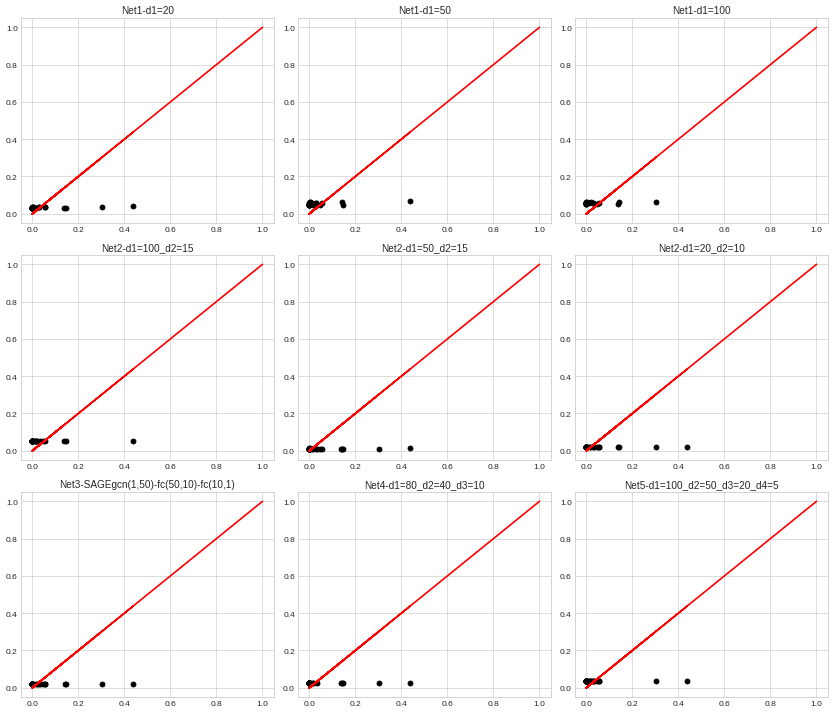

In [187]:
dname='../datasets/precomputed-pytorchg-betweenness/KarateClub_1_nd.pickle'
experimentBlock(dname, res_dict)
reporting(res_dict)